# Load Libraries

In [1]:
import sys, os, pygmt, importlib, re, base64
import numpy              as np
import pandas             as pd
import xarray             as xr
import xesmf              as xe
import matplotlib.pyplot  as plt
import matplotlib.dates   as mdates
from matplotlib.offsetbox import AnchoredOffsetbox, VPacker, TextArea
from datetime             import timedelta, date, datetime
from pathlib              import Path
from dask.distributed     import Client, LocalCluster
from collections          import defaultdict
from scipy.interpolate    import interp1d
from pyproj               import CRS, Transformer
from IPython.display      import Image, HTML, Video
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_toolbox      import SeaIceToolbox

## reload SeaIceToolbox if local changes have been made

In [17]:
import sys
import importlib
# Step 1: Clear all relevant modules
for mod in list(sys.modules):
    if mod.startswith("sea_ice_toolbox") or mod.startswith("sea_ice_"):
        del sys.modules[mod]
# Step 2: Explicit reloads in dependency order
import sea_ice_plotter
import sea_ice_classification
import sea_ice_icebergs
import sea_ice_observations
import sea_ice_metrics
import sea_ice_toolbox
importlib.reload(sea_ice_plotter)
importlib.reload(sea_ice_classification)
importlib.reload(sea_ice_icebergs)
importlib.reload(sea_ice_observations)
importlib.reload(sea_ice_metrics)
importlib.reload(sea_ice_toolbox)
# Step 3: Re-import key class from module (to refresh the class definition)
from sea_ice_toolbox import SeaIceToolbox

# [Simulation Table](https://dpath2o.github.io/AFIM/ice_diag_summary.html)

# [Methodology](https://dpath2o.github.io/AFIM/AFIM_sensitivity_methodology.html)

# ACCESS-OM2-025-ERA5 sea ice data ( **needs only to be run once, after which data can be extracted from local zarr files** )
+ this uses [ACCESS-NRI intake catalog](https://access-nri-intake-catalog.readthedocs.io/en/latest/index.html) through a ``SeaIceToolbox`` method ``load_ACCESS_OM_CICE``

In [ ]:
dt0_str        = "1993-01-01"
dtN_str        = "1999-12-31"
dt_rng_str     = f"{dt0_str[:4]}-{dtN_str[:4]}"
ice_type       = "FI_BT"
SIA_dict       = {}
FIA_dict       = {}
SI_tools       = SeaIceToolbox(sim_name             = "AOM2-ERA5",
                               dt0_str              = dt0_str,
                               dtN_str              = dtN_str,
                               ice_speed_threshold  = 5e-4,
                               ice_speed_type       = "BT",
                               ice_type             = "FI_BT",
                               overwrite_zarr       = True,
                               save_new_figs        = True,
                               show_figs            = True,
                               overwrite_saved_figs = True)

## load ACCESS-OM-025-ERA5 data from ESM datastore then convert to zarr files for easy of use later
+ loading and saving only needs to be done if it has not been done previously
+ running both of these cells takes approximately an hour with the bottleneck at writing to zarr

In [ ]:
AOM2 = SI_tools.load_ACCESS_OM_CICE()

In [ ]:
SI_tools.write_ACCESS_to_monthly_zarr(AOM2, overwrite=True)

## run ACCESS-OM-025-ERA5 through fast ice classification workflow
+ this is a quick process and will save masked zarr dataset

In [ ]:
AOM2_FI_raw = SI_tools.process_daily_cice(ispd_thresh=5e-4,
                                          ivec_type="BT",
                                          overwrite_zarr_group=True)

In [ ]:
AOM2_FI_roll = SI_tools.process_rolling_cice(ispd_thresh=5e-4,
                                             ivec_type="BT",
                                             overwrite_zarr_group=True)

# <span style="color: red;">Study Objectives</span>

## Can a realistic simulation of circumpolar Antarctic fast ice be achieved in CICE-standalone?

+ Sea ice area and volum comparisons are done against [NSIDC](https://nsidc.org/data/g02202/versions/4) and [ACCESS-OM2-025-IAF-ERA](https://forum.access-hive.org.au/t/era-5-forced-access-om2-simulations/1103) (``AOM2-ERA``). The rationale is to show two of my simulations ([AFIM](https://github.com/dpath2o/AFIM), *CICE6-standalone*) against both NSIDC and ACCESS-OM2 as a relative overall gauge of AFIM performance.

+ I've chosen two related AFIM simulations: ``elps-min`` and ``gi-nil``. Both of which have ellispse eccentrincities ($e_{f}=e_{g}=1.2$, and further just abbreviated $e$) and tensile stress parameter ($k_{t}=0.2$) and all other CICE namelist parameters set to *default* standalone configuration, with the exception of the landmask file used (``kmt_file``). ``elps-min`` uses a modified landmask where 25% of the non-isolated grounded iceberg cells remain, whereas ``gi-nil`` uses the same landmask file as ``AOM2-ERA5`` and hence has no grounded iceberg cells.
  
+ Animations of daily sea ice speed ($\sqrt{u^2 + v^2}$) are then shown of the above two AFIM simulations along with AOM2-ERA5 for the same period (Austral winter 1999). Implicitly, the animations show the effect of $e$ and $ktens$ on the coastal icepack, and for the ``elps-min`` simulation the animation clearly shows the significance of grouned icebergs. 

### Sea Ice Area and Volume Comparisons

In [12]:
SIA_dict  = {}
SIV_dict  = {}
FIA_dict  = {}
FIV_dict  = {}
sim_names = ["elps-min", "gi-nil", "AOM2-ERA5"]
for sim in sim_names:
    SI_tools  = SeaIceToolbox(sim_name = sim)
    CICE_all  = SI_tools.load_iceh_zarr()
    CICE_SO   = CICE_all.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
    SIA_dict[sim] = SI_tools.compute_ice_area(CICE_SO['aice'], CICE_SO['tarea'], ice_area_scale=SI_tools.SIC_scale)
    SIV_dict[sim] = SI_tools.compute_ice_volume(CICE_SO['aice'], CICE_SO['hi'], CICE_SO['tarea'])
NSIDC = SI_tools.compute_NSIDC_metrics()
SIA_dict['NSIDC'] = NSIDC['SIA']
P_png = Path(SI_tools.D_graph,"timeseries","SIA_elps-min_gi-nil_AOM2-ERA5_1994-1999.png")
SI_tools.plot_monthly_ice_metric_by_year(SIA_dict, ice_type = "SIA", P_png=P_png)
P_png = Path(SI_tools.D_graph,"timeseries","SIV_elps-min_gi-nil_AOM2-ERA5_1994-1999.png")
SI_tools.plot_monthly_ice_metric_by_year(SIV_dict, ice_type = "SIV", P_png=P_png)

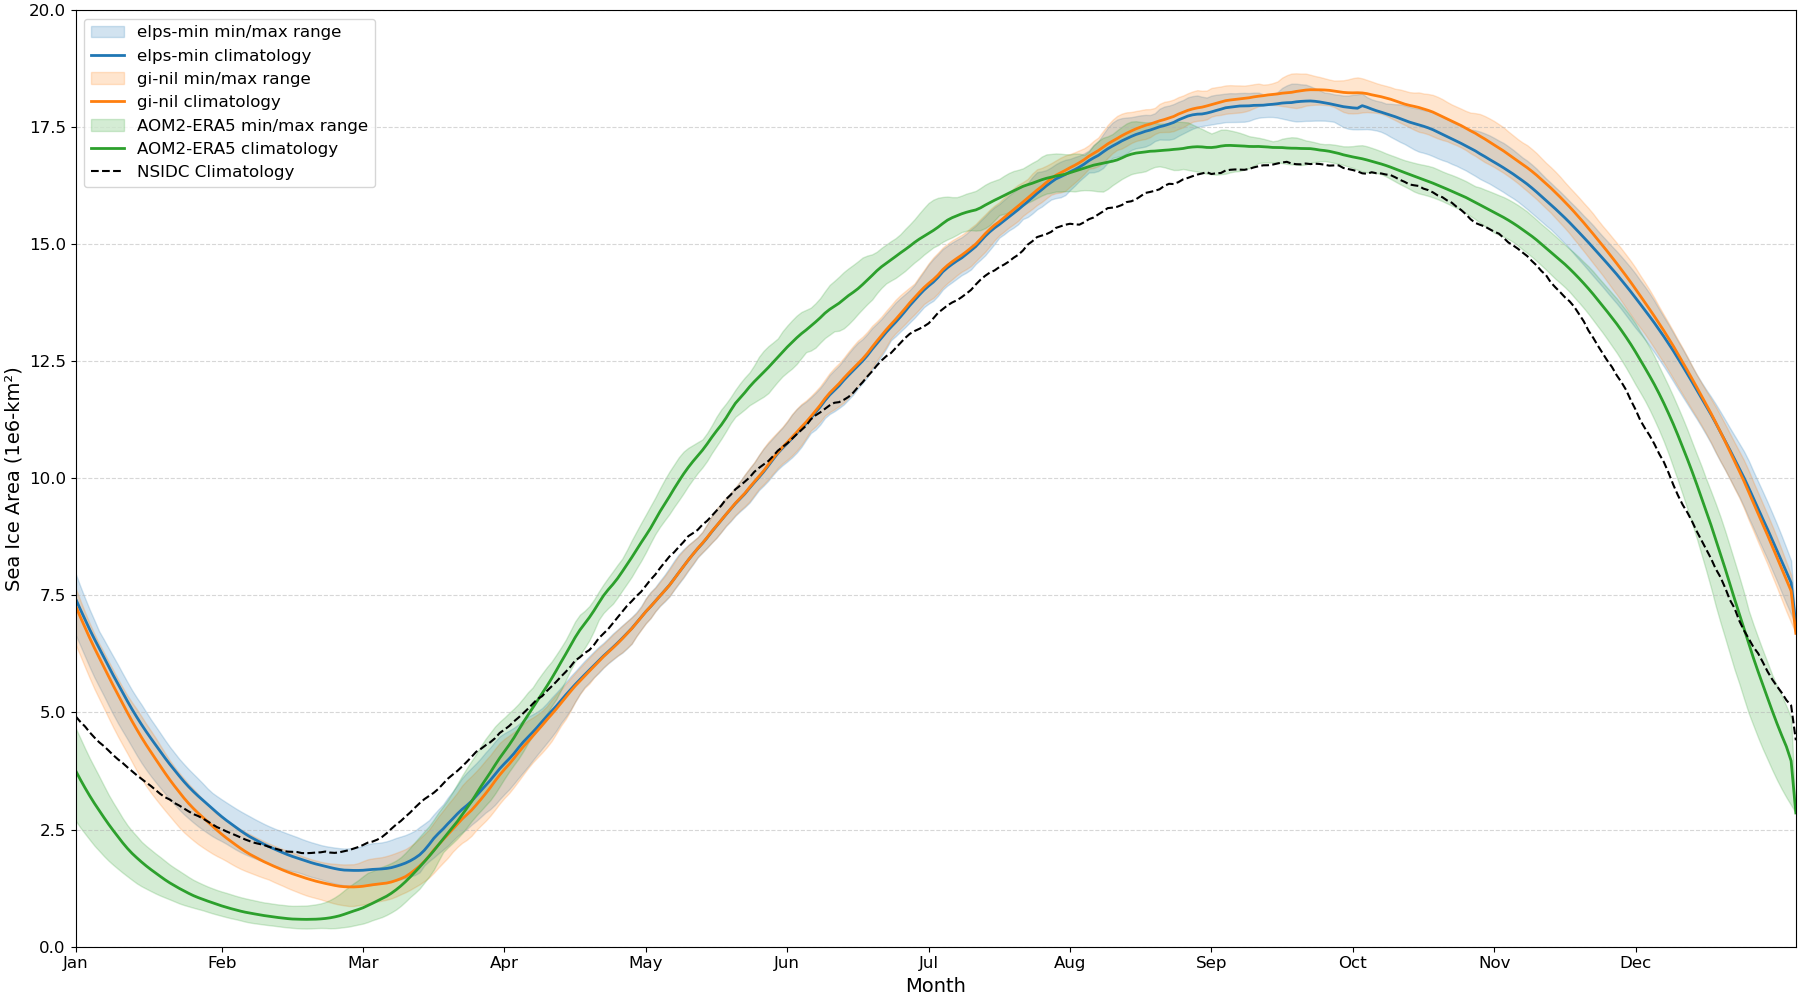

In [9]:
Image(filename='/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/SIA_elps-min_gi-nil_AOM2-ERA5_1994-1999.png')

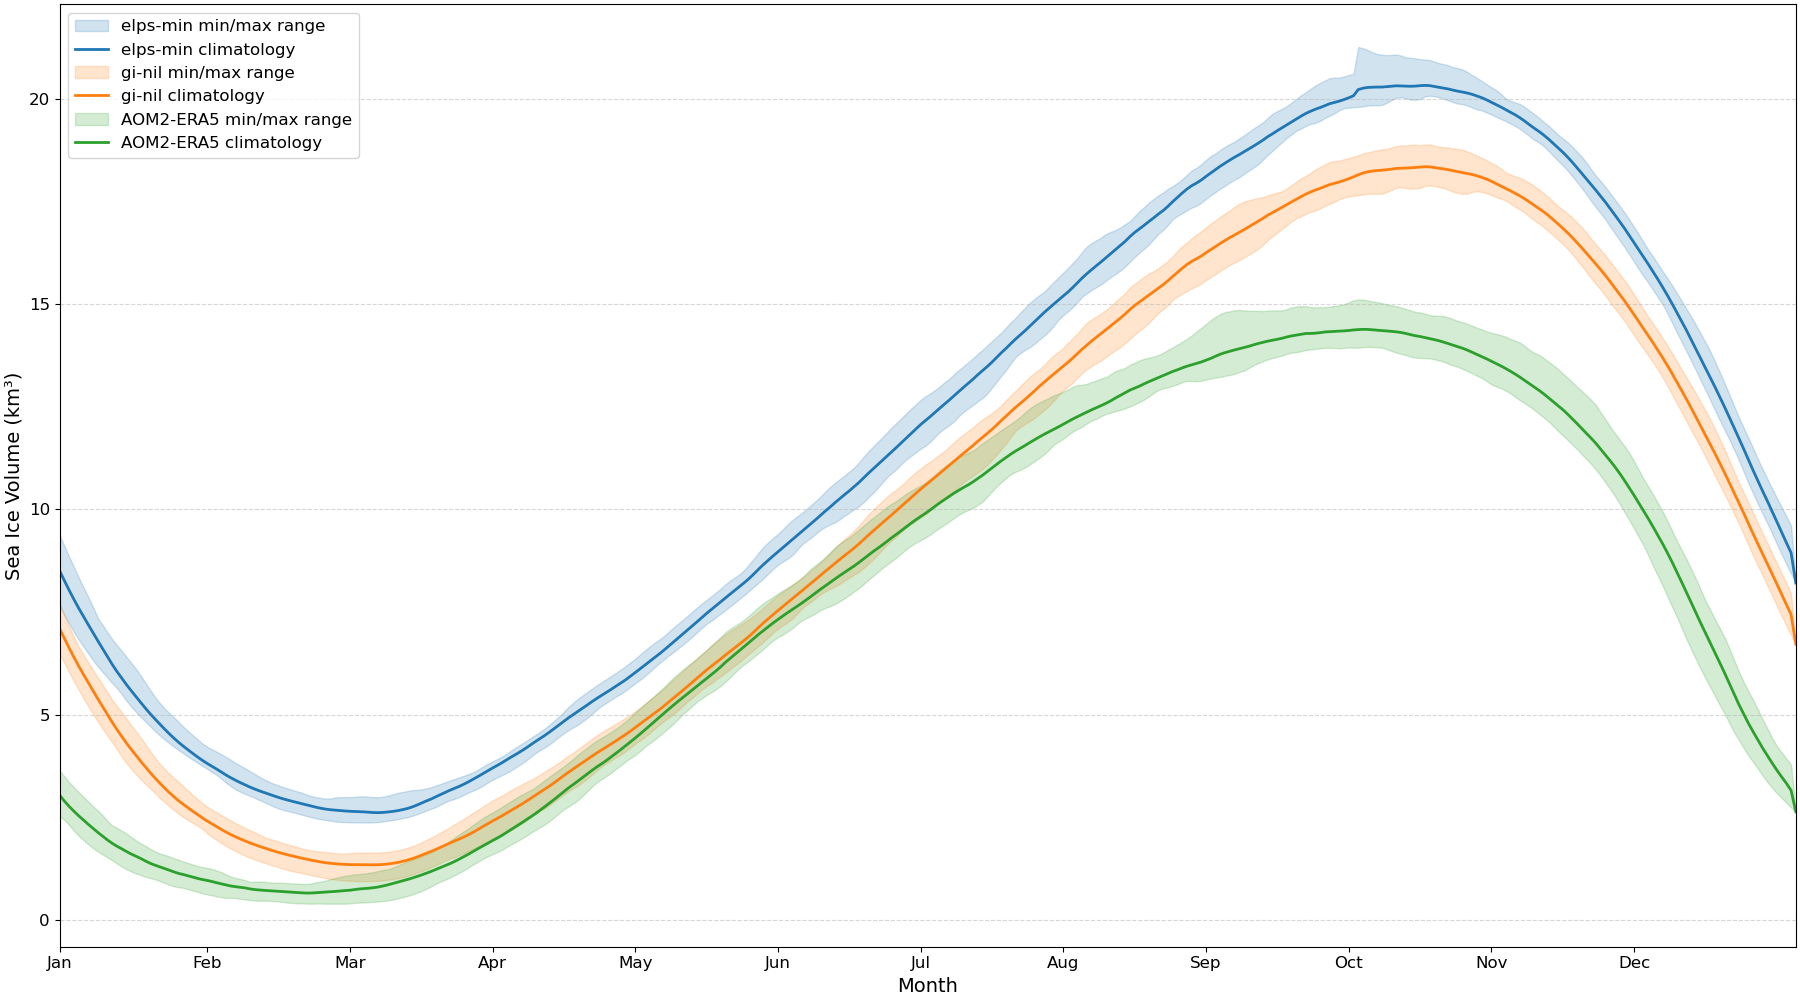

In [9]:
Image(filename='/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/SIV_elps-min_gi-nil_AOM2-ERA5_1994-1999.png')

<a id="spatial-comparisons"></a>
### Spatial Comaprisons 

#### Hemisphere comparisons of sea ice concentration and sea ice thickness

In [4]:
sims    = ["elps-min", "gi-nil", "AOM2-ERA5"]
regions = ["north", "south"]
var_names = ["aice", "hi"]
html_rows = []
for var_name in var_names:
    html_rows.append(f"<h2>{var_name.upper()}</h2>")
    for sim in sims:
        row_html = f"<h3>{sim}</h3><table><tr>"
        for region in regions:
            P_mp4 = Path.home() / "AFIM" / "src" / "AFIM" / "docs" / "figures" / f"{sim}_{var_name}_{region}_1999-winter.mp4"
            print(P_mp4)
            url = f"https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/{P_mp4.name}"
            row_html += f"<td><video width='800' controls><source src='{url}' type='video/mp4'></video><br>{region}</td>"
        row_html += "</tr></table>"
        html_rows.append(row_html)
HTML("".join(html_rows))

/home/581/da1339/AFIM/src/AFIM/docs/figures/elps-min_aice_north_1999-winter.mp4
/home/581/da1339/AFIM/src/AFIM/docs/figures/elps-min_aice_south_1999-winter.mp4
/home/581/da1339/AFIM/src/AFIM/docs/figures/gi-nil_aice_north_1999-winter.mp4
/home/581/da1339/AFIM/src/AFIM/docs/figures/gi-nil_aice_south_1999-winter.mp4
/home/581/da1339/AFIM/src/AFIM/docs/figures/AOM2-ERA5_aice_north_1999-winter.mp4
/home/581/da1339/AFIM/src/AFIM/docs/figures/AOM2-ERA5_aice_south_1999-winter.mp4
/home/581/da1339/AFIM/src/AFIM/docs/figures/elps-min_hi_north_1999-winter.mp4
/home/581/da1339/AFIM/src/AFIM/docs/figures/elps-min_hi_south_1999-winter.mp4
/home/581/da1339/AFIM/src/AFIM/docs/figures/gi-nil_hi_north_1999-winter.mp4
/home/581/da1339/AFIM/src/AFIM/docs/figures/gi-nil_hi_south_1999-winter.mp4
/home/581/da1339/AFIM/src/AFIM/docs/figures/AOM2-ERA5_hi_north_1999-winter.mp4
/home/581/da1339/AFIM/src/AFIM/docs/figures/AOM2-ERA5_hi_south_1999-winter.mp4


north,south
north,south
north,south
north,south
north,south
north,south


#### ice speed comparison of one East Antarctic region

##### ``elps-min``: e = 2, ktens = 0.2, gi-min = 0.25

In [11]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_ispd_BT_Aus_1999-winter.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

##### ``AOM2-ERA5``: e = 2, ktens = None, gi-min = None

In [21]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/AOM2-ERA5_ispd_BT_Aus_1999-winter.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

##### ``gi-nil``: e = 2, ktens = 0.2, gi-min = None

In [25]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/gi-nil_ispd_BT_Aus_1999-winter.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

## Can we realistically simulate the:

1.  fast ice area min

2.  fast ice area max

3.  seasonality

4.  thickness

5.  inter-annual variability

6.  all the while maintaining [pack ice (see above)](#spatial-comparisons)

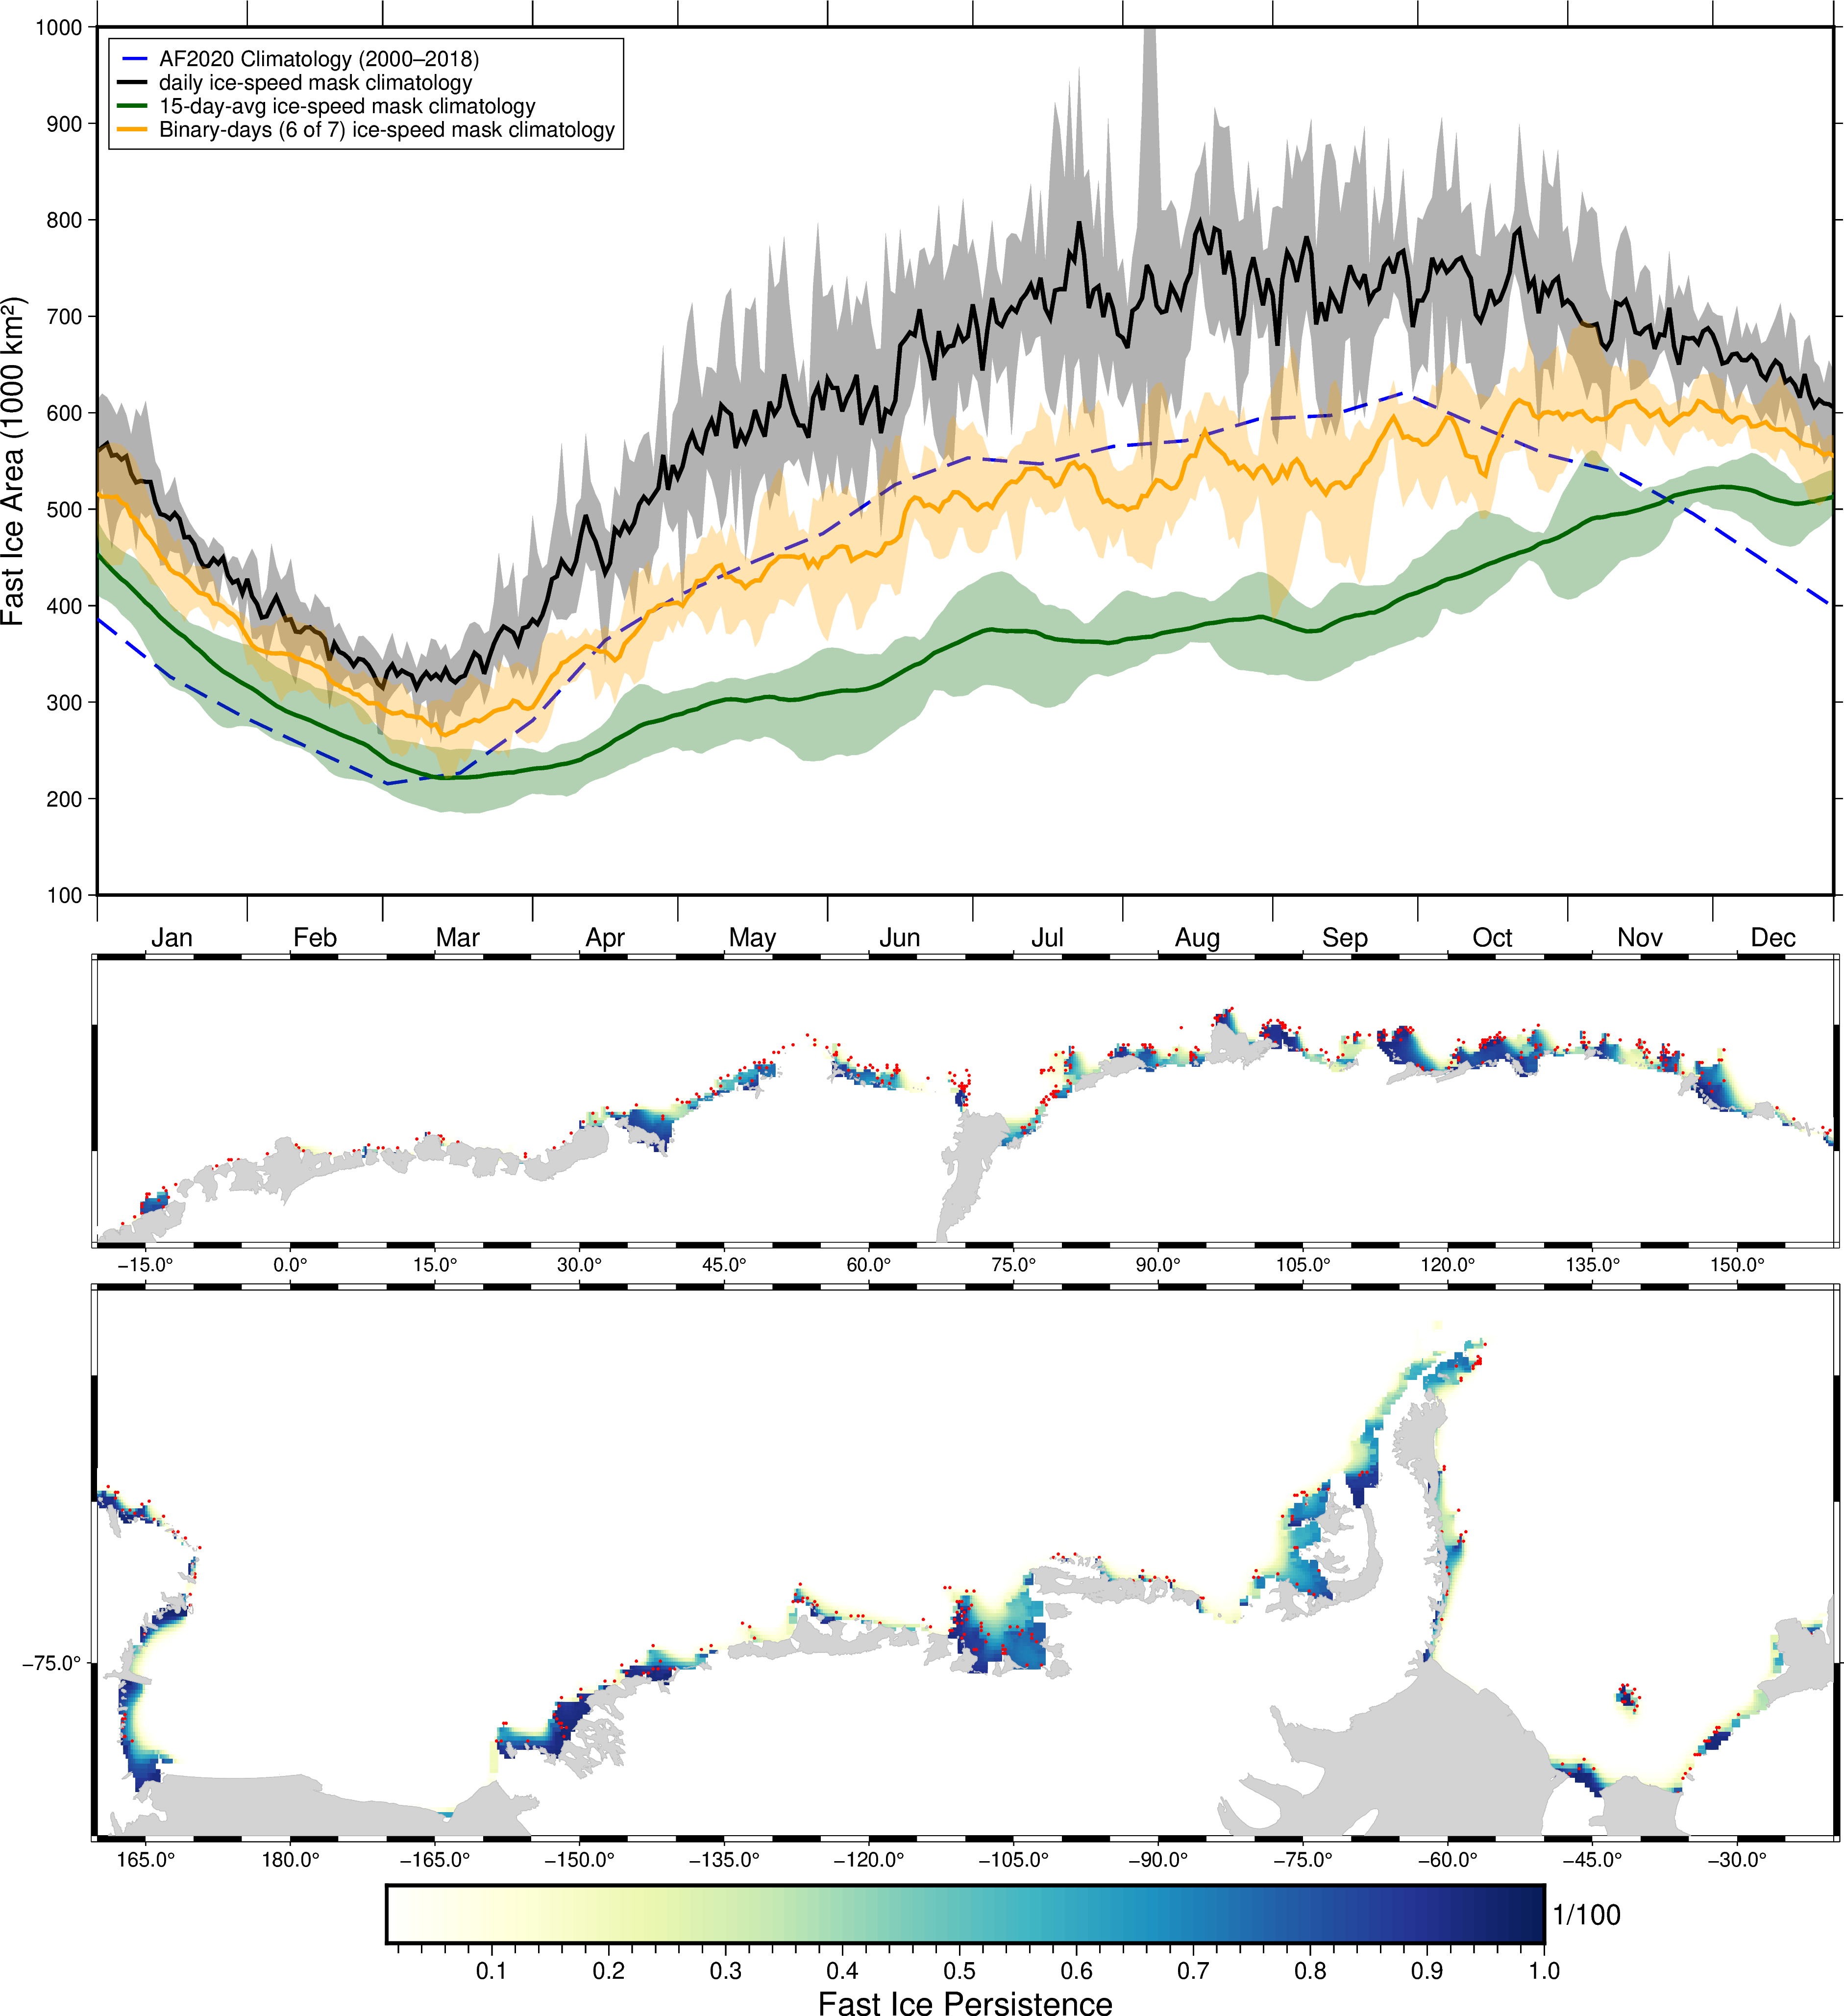

In [12]:
Image("/home/581/da1339/graphical/AFIM/elps-min/FIA_FIP_elps-min_5.0e-4_1993-1999.png")

### Fast ice area min/max for one simulation ``elps-min`` ($e=1.2$, $k_t = 0.2$, $GI-thin=0.25$) versus [AF2020 FI db](https://tc.copernicus.org/articles/15/5061/2021/)

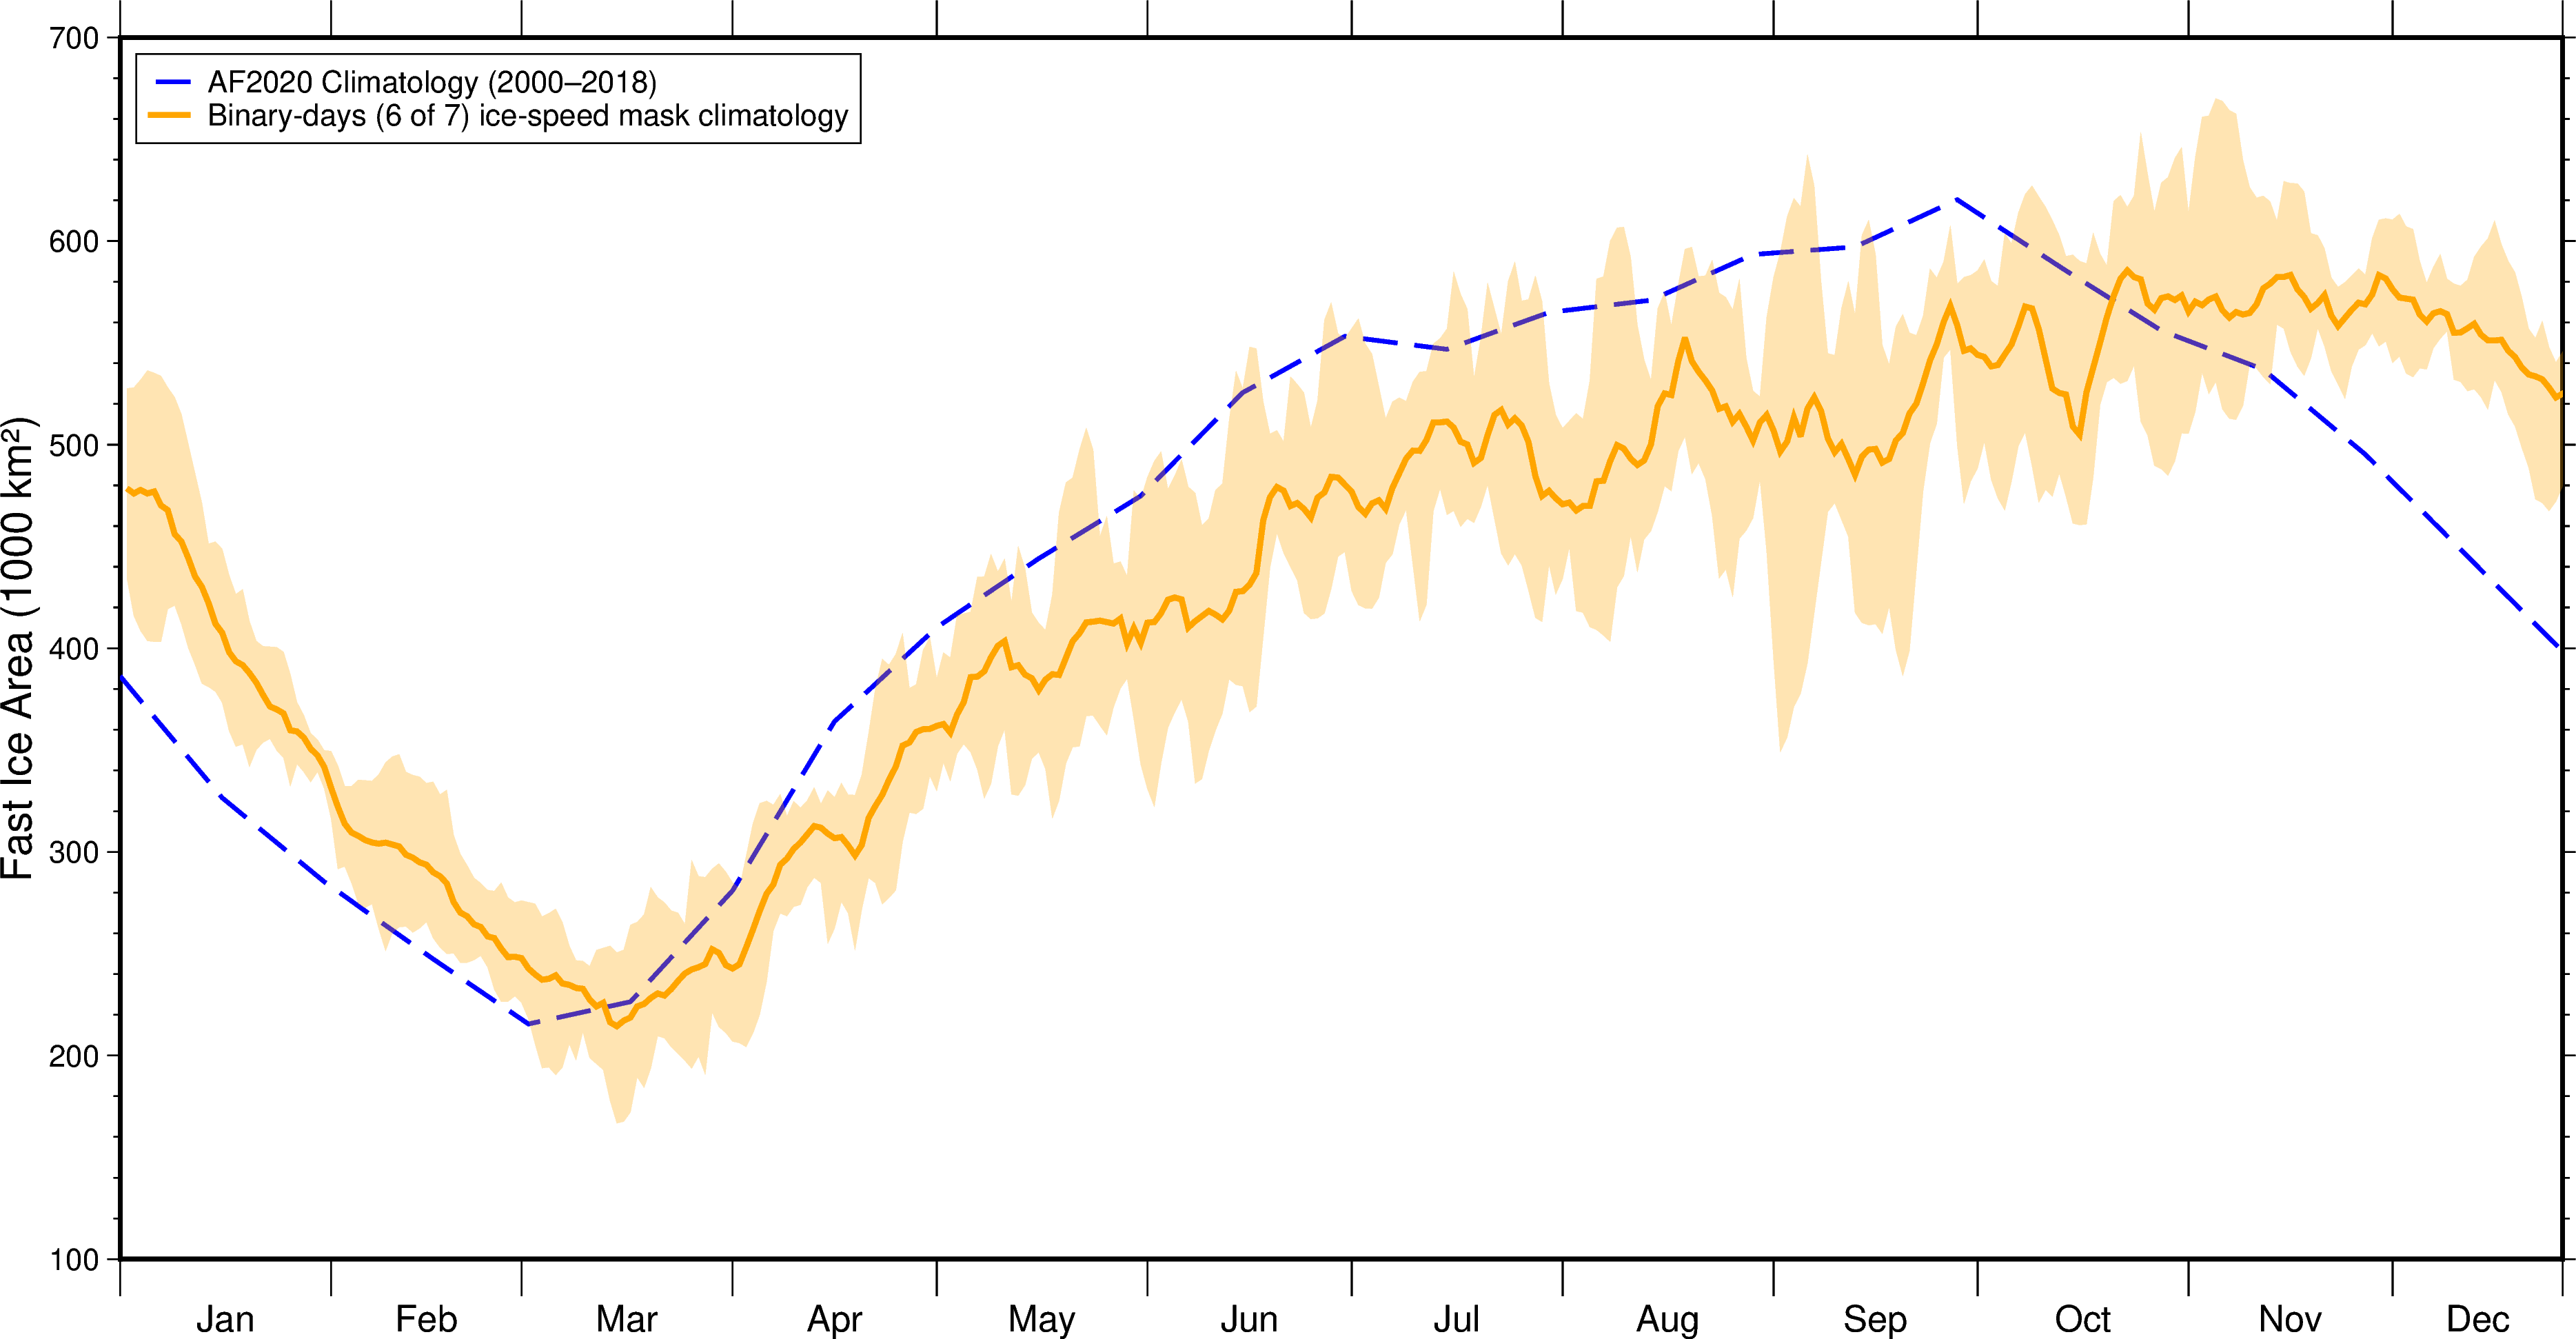

In [33]:
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_elps-min_1993-1999.png")

### Seasonality and inter-annual variability

In [2]:
sim_name = "elps-min"
dt0_str  = "2000-01-01"
dtN_str  = "2018-12-31"
years    = range(2000, 2019)
SI_tools = SeaIceToolbox(sim_name             = sim_name,
                         client               = None,
                         dt0_str              = dt0_str,
                         dtN_str              = dtN_str,
                         ice_speed_threshold  = 5e-4,
                         ice_speed_type       = "ispd_BT",
                         ice_type             = "FI_BT",
                         overwrite_zarr       = False,
                         save_new_figs        = True,
                         show_figs            = True,
                         overwrite_saved_figs = False)
FI_obs_all              = SI_tools.load_AF2020db()
FI_sim_all, CICE_SO_all = SI_tools.load_processed_cice(zarr_CICE=True)
CICE_SO_all             = CICE_SO_all.drop_vars(['time_bounds'])
for year in years:
    SI_tools.logger.info(f"Processing year: {year}")
    P_year = Path(SI_tools.D_sim, f"FI-sim-TS_{sim_name}_{year}.nc")
    if P_year.exists():
        SI_tools.logger.info(f"File {P_year} already exists, skipping...")
        continue
    dt_start           = f"{year}-01-01"
    dt_end             = f"{year}-12-31"
    FI_obs             = FI_obs_all.sel(t_FI_obs=slice(dt_start, dt_end))
    FI_sim             = FI_sim_all.sel(time=slice(dt_start, dt_end))
    CICE_SO            = CICE_SO_all.sel(time=slice(dt_start, dt_end)).drop_vars(['ULON','ULAT','NCAT','ELON','ELAT','NLON','NLAT','time_bounds'], errors='ignore')
    FI_mask            = FI_sim['FI_mask'].chunk({'time': 1, 'nj': 540, 'ni': 1440})
    bool_mask          = SI_tools.boolean_fast_ice(FI_mask)
    CICE_slice         = CICE_SO.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
    CICE_slice         = CICE_slice.chunk({"time": 1, "nj": 540, "ni": 1440})
    bool_mask          = bool_mask.chunk({"time": 1, "nj": 540, "ni": 1440})
    FI_bool            = CICE_slice.where(bool_mask).persist()
    FI_bool["FI_mask"] = FI_mask.persist()
    FI_aln             = SI_tools.coarsen_and_align_simulated_FI_to_observed_FI(FI_bool, FI_obs)
    FI_aln             = FI_aln.rename_vars({'TLAT':'lat','TLON':'lon'})
    FI_aln             = FI_aln.chunk({'t_FI_obs': 1, 'nj': 540, 'ni': 1440})
    FI_aln.load().to_netcdf(P_year, mode="w", engine="netcdf4")
    SI_tools.logger.info(f"Saved {P_year}")

2025-06-17 09:33:43,423 - INFO - log file initialised: /g/data/gv90/da1339/logs/SeaIceProcessor_FI_elps-min.log
2025-06-17 09:33:45,487 - INFO - Initialized new Dask client.
2025-06-17 09:33:45,489 - INFO - Dask distributed client can be accessed at url /proxy/8787/status
2025-06-17 09:33:45,491 - INFO - hemisphere initialised: SH
2025-06-17 09:33:45,497 - INFO - Loading existing AF2020 observational Zarr file: /g/data/gv90/da1339/SeaIce/FI_obs/AF-FI-2020db_org-timestep_reG.zarr
2025-06-17 09:33:51,051 - INFO - Zarr load/generation completed in 5.56 seconds
INFO:elps-min:Zarr load/generation completed in 5.56 seconds
2025-06-17 09:33:54,496 - INFO - Found 228 zarr files
INFO:elps-min:Found 228 zarr files
2025-06-17 09:35:48,698 - INFO - Loaded FI_BT: 6921 time steps from 228 files
INFO:elps-min:Loaded FI_BT: 6921 time steps from 228 files
2025-06-17 09:35:48,700 - INFO - Load monthly iceh_*.zarr files between 2000-01-01 and 2018-12-31
INFO:elps-min:Load monthly iceh_*.zarr files betwee

In [ ]:
import glob
pattern = str(Path(SI_tools.D_sim, f"FI-sim-TS_{sim_name}_*.nc"))
files = sorted(glob.glob(pattern))
FI_sim = xr.open_mfdataset(files, engine="netcdf4")
SI_tools = SeaIceToolbox(sim_name = "elps-min")

In [11]:
FI_mets = xr.open_dataset("/g/data/gv90/da1339/afim_output/elps-min/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_bool_mets.zarr")
FI_mets

<xarray.Dataset> Size: 28MB
Dimensions:       (time: 2556, nj: 540, ni: 1440, year: 7)
Coordinates:
    TLAT          (nj, ni) float32 3MB ...
    TLON          (nj, ni) float32 3MB ...
    ULAT          (nj, ni) float32 3MB ...
    ULON          (nj, ni) float32 3MB ...
    lat           (nj, ni) float64 6MB ...
    lon           (nj, ni) float64 6MB ...
  * ni            (ni) int64 12kB 0 1 2 3 4 5 ... 1434 1435 1436 1437 1438 1439
  * nj            (nj) int64 4kB 0 1 2 3 4 5 6 7 ... 533 534 535 536 537 538 539
  * time          (time) datetime64[ns] 20kB 1993-01-01 ... 1999-12-31
  * year          (year) int64 56B 1993 1994 1995 1996 1997 1998 1999
Data variables:
    FIA           (time) float32 10kB ...
    FIP           (nj, ni) float32 3MB ...
    FIP_mean      float64 8B ...
    FIP_std       float64 8B ...
    doy_max       int64 8B ...
    duration      (year) int64 56B ...
    growth_rate   float64 8B ...
    max_FI_dist   float64 8B ...
    max_growth    float64 8B ...
    mean_FI_dist  float64 8B ...
    onset_doy     int64 8B ...
    rmse_to_obs   float64 8B ...

In [ ]:
FIA_dict = {}
FIA_dict['FIA_obs'] = SI_tools.compute_ice_area(FI_obs_all['FI'].isel(nj=SI_tools.hemisphere_dict['nj_slice']) ,
                                                FI_sim.isel(t_FI_obs=0)['tarea'],
                                                ice_area_scale=SI_tools.FIC_scale )
FIA_dict['FIA_sim'] = SI_tools.compute_ice_area(FI_sim['aice'] ,
                                                FI_sim['tarea'],
                                                ice_area_scale=SI_tools.FIC_scale )

2025-06-17 09:56:17,830 - WARNING - Dask client already exists but was not passed to SeaIceToolbox.
2025-06-17 09:56:17,833 - WARNING - Please explicitly pass the existing Dask client using `client=...` to avoid confusion.
2025-06-17 09:56:17,835 - INFO - Dask distributed client can be accessed at url /proxy/8787/status
INFO:elps-min:Dask distributed client can be accessed at url /proxy/8787/status
2025-06-17 09:56:17,837 - INFO - hemisphere initialised: SH
INFO:elps-min:hemisphere initialised: SH
2025-06-17 09:56:18,164 - INFO - 66791608021.64 m^2 total circumpolar grounded iceberg area for elps-min
INFO:elps-min:66791608021.64 m^2 total circumpolar grounded iceberg area for elps-min
2025-06-17 09:56:18,166 - INFO - 🧮 Spatially-integrating the product of sea ice concentrations and grid cell areas
INFO:elps-min:🧮 Spatially-integrating the product of sea ice concentrations and grid cell areas
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distribute

plot [ERROR]: Colorname C0 not recognized!
plot [WARNING]: Representation of pen color (C0) not recognized. Using default.
plot [ERROR]: Colorname C1 not recognized!
plot [WARNING]: Representation of pen color (C1) not recognized. Using default.


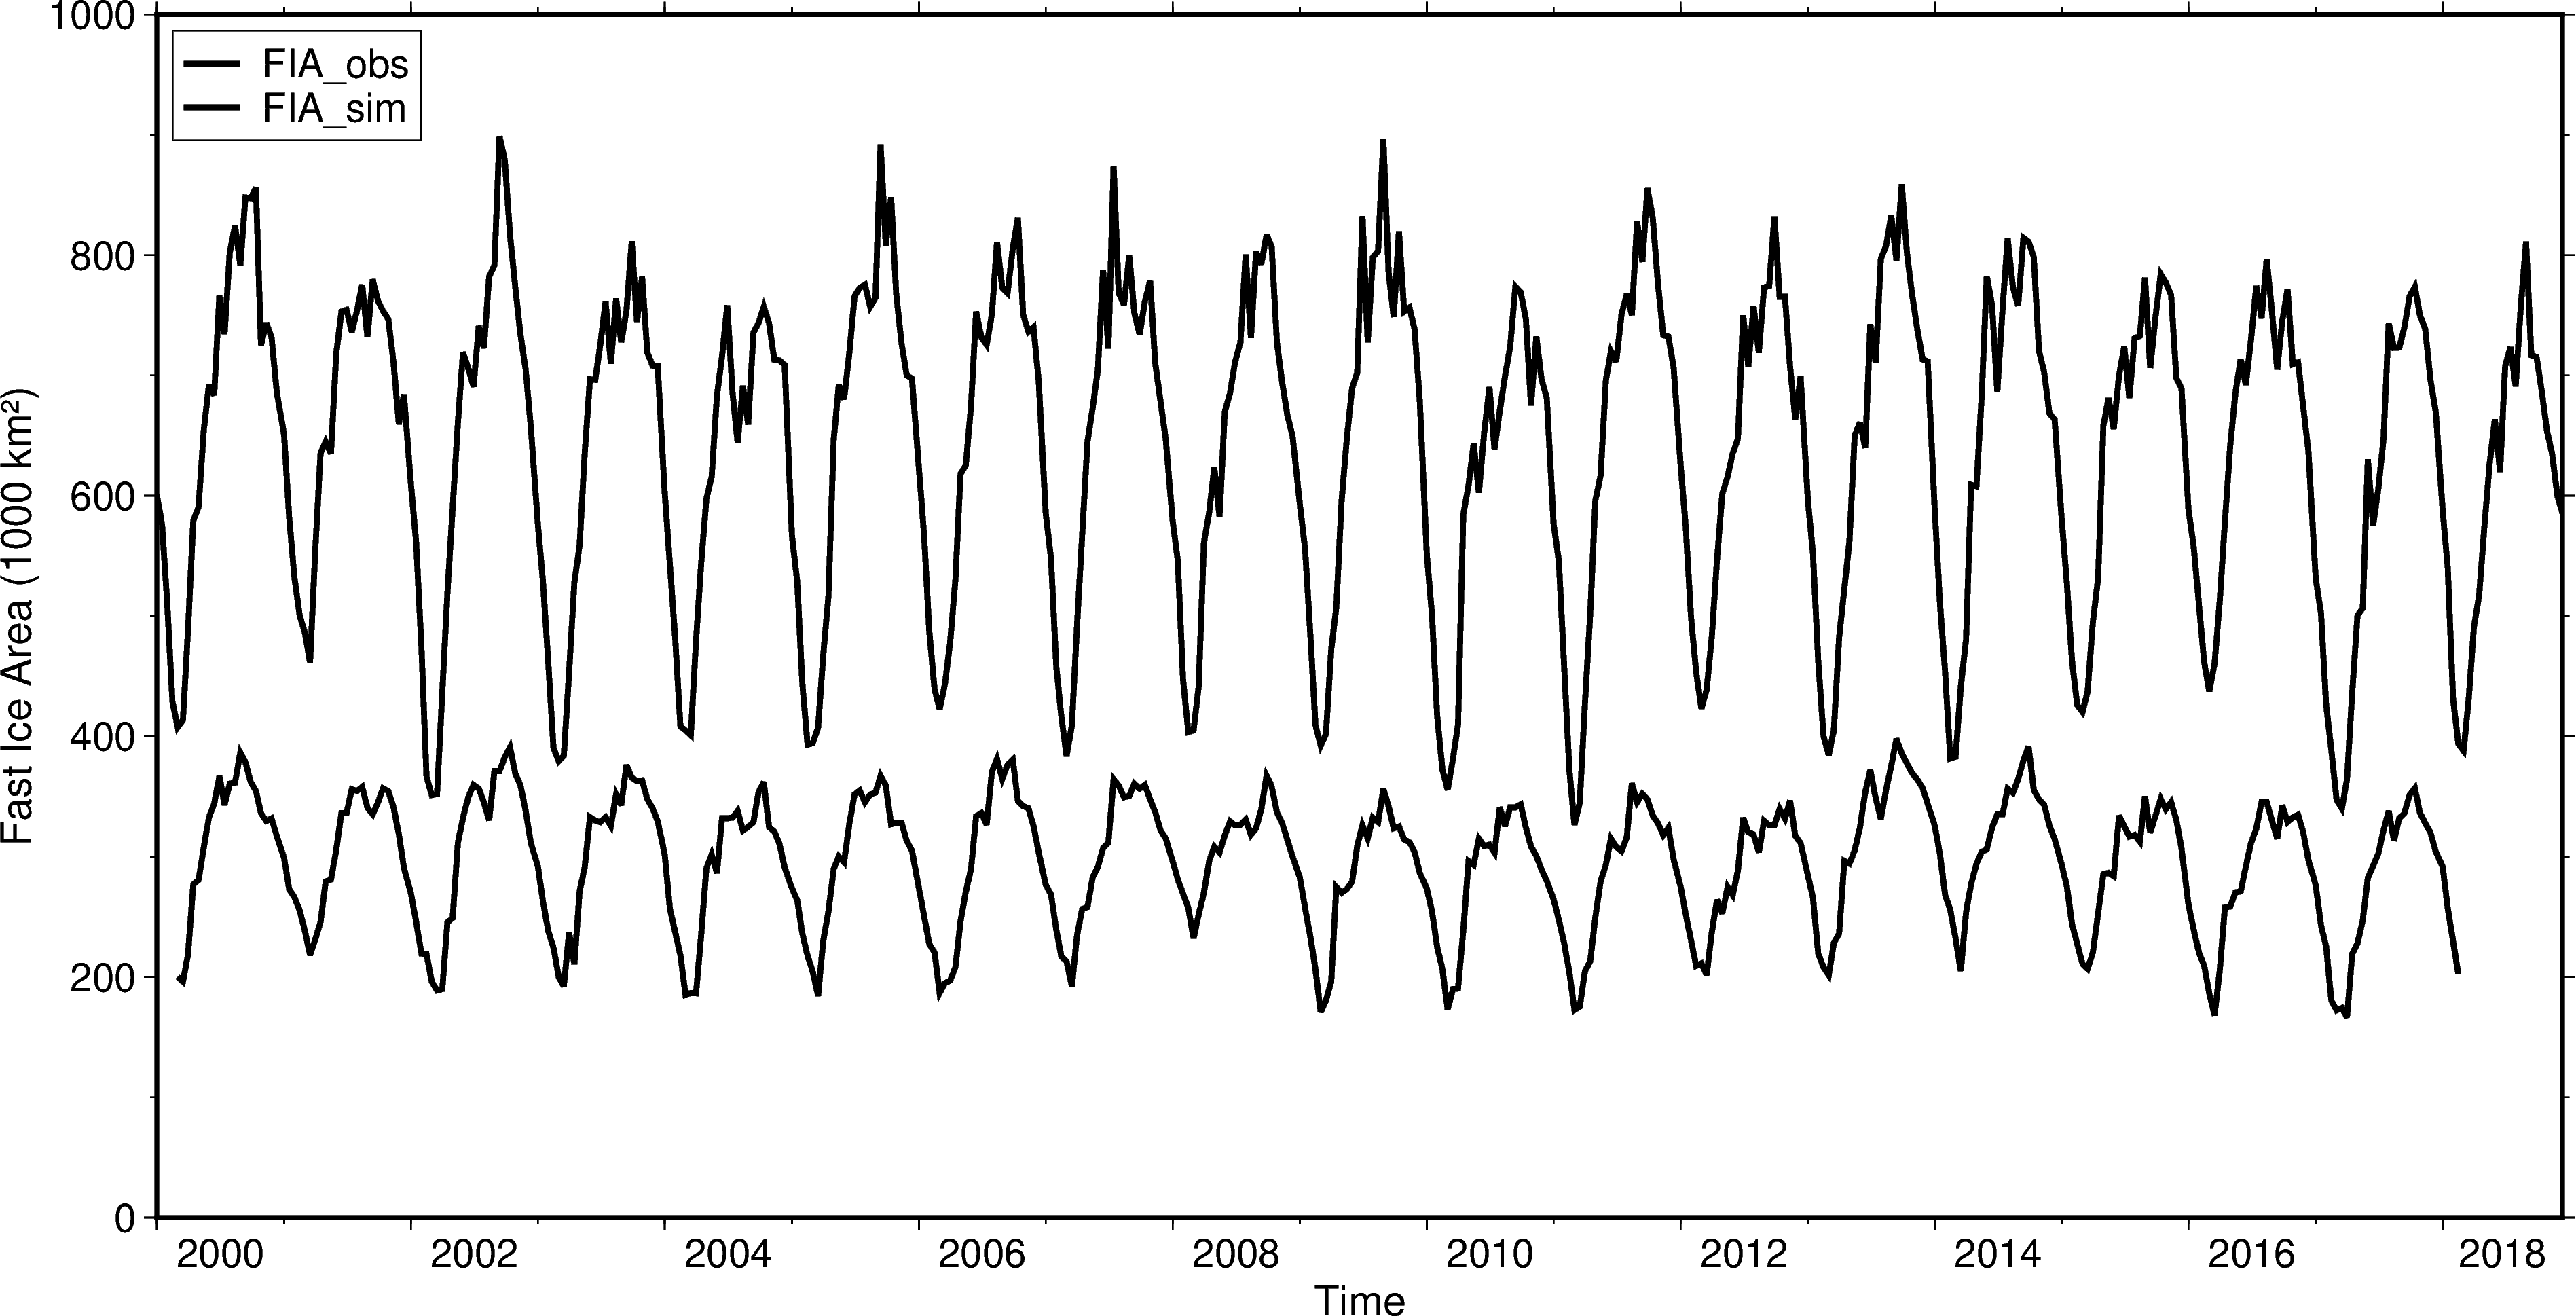

In [9]:
SI_tools.pygmt_plot_continuous_timeseries( FIA_dict , time_coord_name="t_FI_obs" )

## Which CICE parameter(s) is the model most sensitive to?

1.  rheological parameters

2.  What is the optimal concentration of grounded icebergs that should
    be used?

3.  Is there a relationship between sea ice speed threshold and fast ice
    area?

## Do the thermodynamics and mechanical dynamics continue to \`\`behave\'\' when CICE is *heavily tuned* for fast ice?

(limited due to standalone configuration)

### Is there a relationship between sea ice speed threshold and fast ice area?

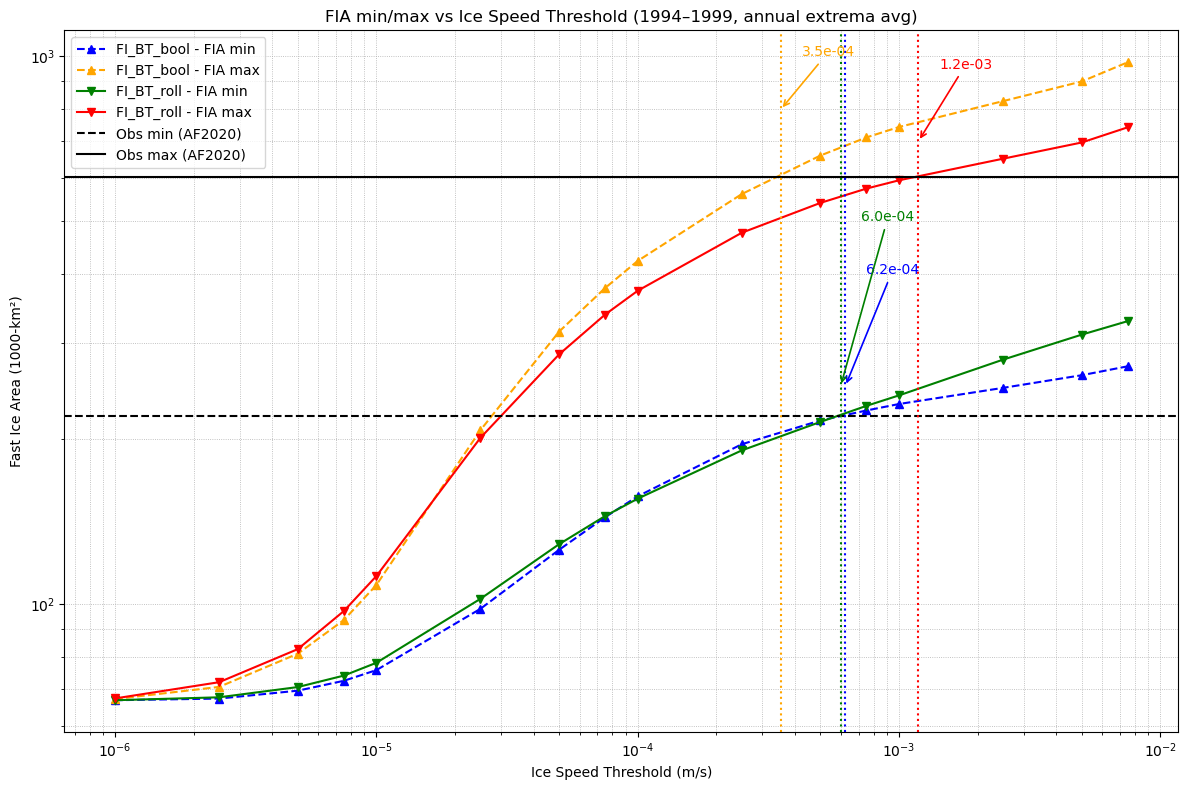

<Figure size 640x480 with 0 Axes>

In [39]:
log_scale = True  # Set to False for linear
if log_scale:
    F_name = "ispd-thresh_vs_FIA-min-max_logscale.png"
else:
    F_name = "ispd-thresh_vs_FIA-min-max.png"
sim_name = "elps-min"
base_dir = f"/g/data/gv90/da1339/afim_output/{sim_name}/zarr"
threshold_dirs = sorted([d for d in os.listdir(base_dir) if d.startswith("ispd_thresh_")])
ispd_vals = [float(d.split('_')[2]) for d in threshold_dirs]
FIA_stats = {"FI_BT_bool": {},
             "FI_BT_roll": {}}
def get_fia_stats(path):
    try:
        ds = xr.open_zarr(path)
        fia = ds["FIA"].sel(time=slice("1994-01-01", "1999-12-31"))
        # Group by year and compute annual min/max
        fia_by_year = fia.groupby("time.year")
        min_by_year = fia_by_year.min(dim="time")
        max_by_year = fia_by_year.max(dim="time")
        # Compute the mean of annual min/max
        return float(min_by_year.mean().values), float(max_by_year.mean().values)
    except Exception as e:
        print(f"Error with {path}: {e}")
        return np.nan, np.nan
# Define a function to interpolate where the method curve crosses the observed value
def interpolate_x(x, y, y_obs):
    x = np.array(x)
    y = np.array(y)
    for i in range(len(x) - 1):
        if np.isnan(y[i]) or np.isnan(y[i + 1]):
            continue
        if (y[i] - y_obs) * (y[i + 1] - y_obs) < 0:
            # Linear interpolation in log or linear space depending on axis setting
            return x[i] + (y_obs - y[i]) * (x[i + 1] - x[i]) / (y[i + 1] - y[i])
    return None

for dir_name in threshold_dirs:
    threshold = float(dir_name.split("_")[2])
    # Paths
    bool_path = os.path.join(base_dir, dir_name, "metrics", "FI_BT_bool_mets.zarr")
    roll_path = os.path.join(base_dir, dir_name, "metrics", "FI_BT_roll_mets.zarr")
    # Load stats
    min_b, max_b = get_fia_stats(bool_path)
    min_r, max_r = get_fia_stats(roll_path)
    # Store in dict
    FIA_stats["FI_BT_bool"][threshold] = {"min": min_b, "max": max_b}
    FIA_stats["FI_BT_roll"][threshold] = {"min": min_r, "max": max_r}

# Sort thresholds
thresholds = sorted(FIA_stats['FI_BT_bool'].keys())

# Prepare data
bool_min = [FIA_stats['FI_BT_bool'][t]['min'] for t in thresholds]
bool_max = [FIA_stats['FI_BT_bool'][t]['max'] for t in thresholds]
roll_min = [FIA_stats['FI_BT_roll'][t]['min'] for t in thresholds]
roll_max = [FIA_stats['FI_BT_roll'][t]['max'] for t in thresholds]
# Compute interpolated x-values for each intersection
bool_min_x = interpolate_x(thresholds, bool_min, obs_min)
bool_max_x = interpolate_x(thresholds, bool_max, obs_max)
roll_min_x = interpolate_x(thresholds, roll_min, obs_min)
roll_max_x = interpolate_x(thresholds, roll_max, obs_max)

# Observed min/max
obs_min = 221
obs_max = 601

plt.figure(figsize=(12, 8))
if log_scale:
    plt.xscale("log")
    plt.yscale("log")

# Plot the curves
plt.plot(thresholds, bool_min, 'b--', marker='^', label="FI_BT_bool - FIA min")
plt.plot(thresholds, bool_max, 'orange', linestyle='--', marker='^', label="FI_BT_bool - FIA max")
plt.plot(thresholds, roll_min, 'g-', marker='v', label="FI_BT_roll - FIA min")
plt.plot(thresholds, roll_max, 'r-', marker='v', label="FI_BT_roll - FIA max")

# Horizontal obs lines
plt.axhline(obs_min, color='k', linestyle='--', label="Obs min (AF2020)")
plt.axhline(obs_max, color='k', linestyle='-', label="Obs max (AF2020)")

# Arrow annotations for vertical thresholds
arrowprops = dict(arrowstyle="->", linewidth=1.2)

if bool_min_x:
    plt.axvline(bool_min_x, color='blue', linestyle=':')
    plt.annotate(f"{bool_min_x:.1e}",
                 xy=(bool_min_x, 250), xytext=(bool_min_x * 1.2, 400),
                 arrowprops={**arrowprops, 'color': 'blue'}, color='blue')

if bool_max_x:
    plt.axvline(bool_max_x, color='orange', linestyle=':')
    plt.annotate(f"{bool_max_x:.1e}",
                 xy=(bool_max_x, 800), xytext=(bool_max_x * 1.2, 1000),
                 arrowprops={**arrowprops, 'color': 'orange'}, color='orange')

if roll_min_x:
    plt.axvline(roll_min_x, color='green', linestyle=':')
    plt.annotate(f"{roll_min_x:.1e}",
                 xy=(roll_min_x, 250), xytext=(roll_min_x * 1.2, 500),
                 arrowprops={**arrowprops, 'color': 'green'}, color='green')

if roll_max_x:
    plt.axvline(roll_max_x, color='red', linestyle=':')
    plt.annotate(f"{roll_max_x:.1e}",
                 xy=(roll_max_x, 700), xytext=(roll_max_x * 1.2, 950),
                 arrowprops={**arrowprops, 'color': 'red'}, color='red')

# Labels and formatting
plt.xlabel("Ice Speed Threshold (m/s)")
plt.ylabel("Fast Ice Area (1000-km²)")
plt.title("FIA min/max vs Ice Speed Threshold (1994–1999, annual extrema avg)")
plt.legend()
plt.grid(True, which='both' if log_scale else 'major', linestyle=':', linewidth=0.6)
plt.tight_layout()
plt.show()
plt.savefig(f"/g/data/gv90/da1339/GRAPHICAL/AFIM/{sim_name}/{F_name}")